# 학생 성적 예측 및 영향 요인 분석 (xAPI Edu Data)
**Author**: Antigravity
**Date**: 2026-01-05
**Goal**: 학생들의 학습 행동 데이터(출석, 토론, 과제 확인 등)를 기반으로 성적 등급(L, M, H)을 예측하고, 성적에 영향을 미치는 주요 요인을 분석합니다.

## 0. 환경 설정 (Environment Setup)
필요한 라이브러리를 로드합니다. Scikit-learn 외에 강력한 성능의 XGBoost를 추가로 사용합니다.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Config
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print("Libraries loaded.")

Libraries loaded.


## 1. 데이터 적재 및 정제 (Obtain & Scrub)
데이터를 로드하고 결측치 및 데이터 타입을 확인합니다.


In [2]:
# 데이터 로드
try:
    df = pd.read_csv('../../data/xAPI-Edu-Data.csv')
    print(f"Data Shape: {df.shape}")
    display(df.head())
    print("-" * 30)
    df.info()
except FileNotFoundError:
    print("파일을 찾을 수 없습니다.")

Data Shape: (480, 17)


,gender,NationalITy,PlaceofBirth,StageID,GradeID,SectionID,Topic,Semester,Relation,raisedhands,VisITedResources,AnnouncementsView,Discussion,ParentAnsweringSurvey,ParentschoolSatisfaction,StudentAbsenceDays,Class
0,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,15,16,2,20,Yes,Good,Under-7,M
1,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,20,20,3,25,Yes,Good,Under-7,M
2,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,10,7,0,30,No,Bad,Above-7,L
3,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,30,25,5,35,No,Bad,Above-7,L
4,M,KW,KuwaIT,lowerlevel,G-04,A,IT,F,Father,40,50,12,50,No,Bad,Above-7,M


------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   gender                    480 non-null    object
 1   NationalITy               480 non-null    object
 2   PlaceofBirth              480 non-null    object
 3   StageID                   480 non-null    object
 4   GradeID                   480 non-null    object
 5   SectionID                 480 non-null    object
 6   Topic                     480 non-null    object
 7   Semester                  480 non-null    object
 8   Relation                  480 non-null    object
 9   raisedhands               480 non-null    int64 
 10  VisITedResources          480 non-null    int64 
 11  AnnouncementsView         480 non-null    int64 
 12  Discussion                480 non-null    int64 
 13  ParentAnsweringSurvey     480 non-null    object


### 데이터 품질 점검
- **결측치**: `isnull().sum()`으로 확인.
- **Target(`Class`) 분포**: 클래스 불균형 여부 확인 (L, M, H 비율).


Missing Values:
 gender                      0
NationalITy                 0
PlaceofBirth                0
StageID                     0
GradeID                     0
SectionID                   0
Topic                       0
Semester                    0
Relation                    0
raisedhands                 0
VisITedResources            0
AnnouncementsView           0
Discussion                  0
ParentAnsweringSurvey       0
ParentschoolSatisfaction    0
StudentAbsenceDays          0
Class                       0
dtype: int64

Target Distribution (Class):
Class
M    0.439583
H    0.295833
L    0.264583
Name: proportion, dtype: float64


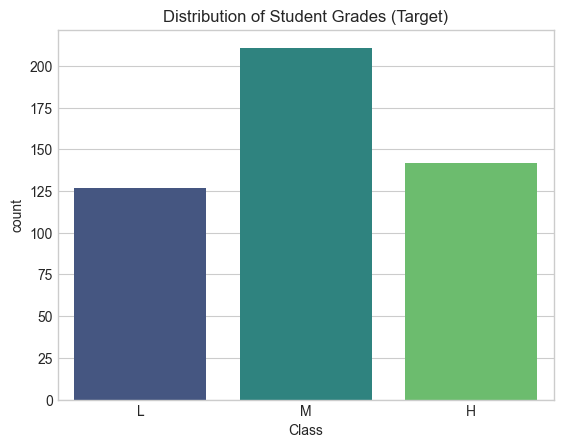

In [3]:
print("Missing Values:\n", df.isnull().sum())

print("\nTarget Distribution (Class):")
print(df['Class'].value_counts(normalize=True))

sns.countplot(x='Class', data=df, order=['L', 'M', 'H'], palette='viridis')
plt.title('Distribution of Student Grades (Target)')
plt.show()

## 2. 탐색적 데이터 분석 (EDA)
**질문(Question)**:
1. 수업 참여도(`raisedhands`)가 높은 학생은 성적도 높을까?
2. 부모의 설문 응답 여부(`ParentAnsweringSurvey`)가 자녀 성적과 관련이 있을까?


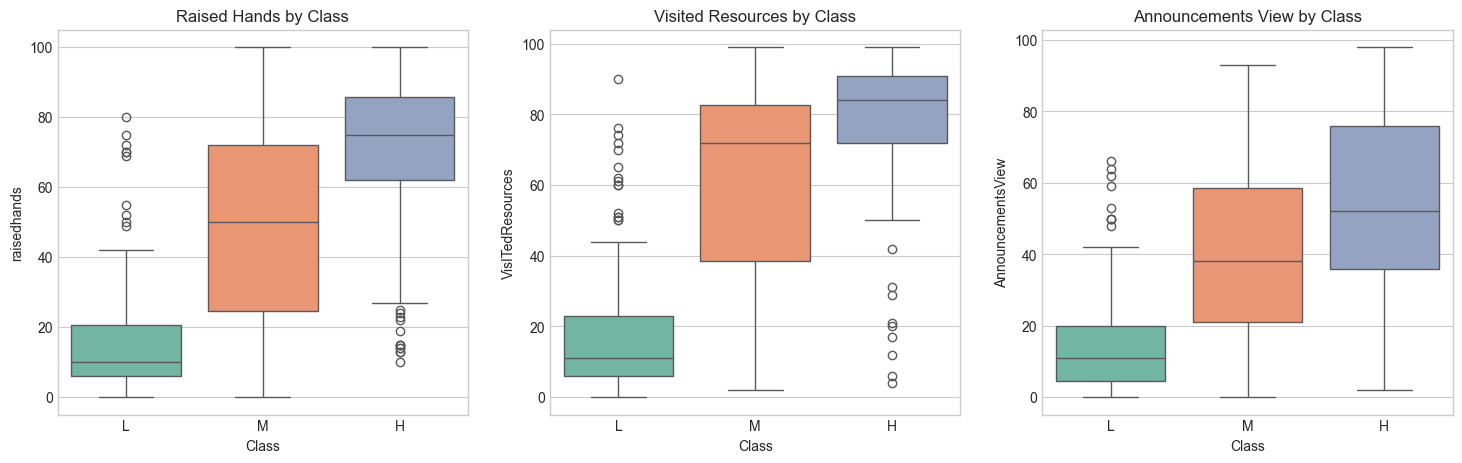

In [4]:
# 1. 수업 참여도 vs 성적
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x='Class', y='raisedhands', data=df, order=['L', 'M', 'H'], ax=axes[0], palette='Set2')
axes[0].set_title('Raised Hands by Class')

sns.boxplot(x='Class', y='VisITedResources', data=df, order=['L', 'M', 'H'], ax=axes[1], palette='Set2')
axes[1].set_title('Visited Resources by Class')

sns.boxplot(x='Class', y='AnnouncementsView', data=df, order=['L', 'M', 'H'], ax=axes[2], palette='Set2')
axes[2].set_title('Announcements View by Class')

plt.show()

**Insight**:
- **L 등급(Low)** 학생들은 손을 드는 횟수나 리소스 방문 횟수가 현저히 낮은 경향을 보입니다.
- **M, H 등급**으로 갈수록 참여도가 높아지는 양의 상관관계가 관찰됩니다.


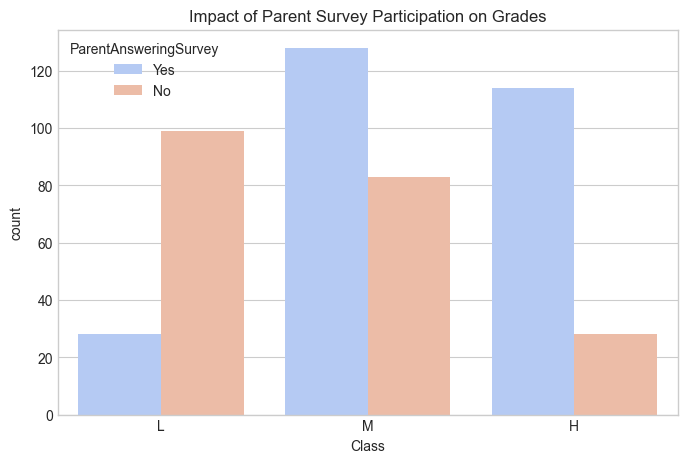

In [5]:
# 2. 부모 설문 응답 여부 vs 성적
plt.figure(figsize=(8, 5))
sns.countplot(x='Class', hue='ParentAnsweringSurvey', data=df, order=['L', 'M', 'H'], palette='coolwarm')
plt.title('Impact of Parent Survey Participation on Grades')
plt.show()

**Insight**:
- 부모가 설문에 응답한 경우(`Yes`) 자녀가 H 등급일 확률이 높고 L 등급일 확률이 낮습니다.
- 부모의 관심이 학생 성취도에 긍정적인 영향을 미침을 시사합니다.


## 3. 모델링 (Modeling)
**Strategy**:
- **Preprocessing**:
    - **Ordinal Encoding**: `Class` (L=0, M=1, H=2) - 순서가 중요하므로 라벨 인코딩.
    - **Label Encoding**: 기타 범주형 변수들.
- **Models**:
    1.  **Logistic Regression**: 변수 영향력(계수) 해석 용이.
    2.  **XGBoost**: 높은 예측 성능 및 Feature Importance 제공.


In [6]:
# 전처리
X = df.drop('Class', axis=1)
y = df['Class']

# Target Encoding (L=0, M=1, H=2 for ordinality)
class_map = {'L': 0, 'M': 1, 'H': 2}
y_encoded = y.map(class_map)

# Feature Encoding (Label Encoding used for simplicity with Trees, One-Hot is better for Logistic but trying uniform approach first or simple Label for categories)
# For Logistic Regression, One-Hot is better. XGBoost handles both well. 
# Let's use pd.get_dummies for categorical features to support Logistic Regression properly.

categorical_cols = X.select_dtypes(include=['object']).columns
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print(f"Encoded Shape: {X_encoded.shape}")

# Split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scaling (For Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Encoded Shape: (480, 60)


In [7]:
# 모델 학습 및 평가
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='mlogloss')
}

predictions = {}

for name, model in models.items():
    # Train
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        # XGBoost doesn't strictly need scaling but it's fine
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    predictions[name] = y_pred
    
    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    print(f"--- {name} ---")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=['L', 'M', 'H']))
    print("-" * 30)

--- Logistic Regression ---
Accuracy: 0.6771
              precision    recall  f1-score   support

           L       0.72      0.81      0.76        26
           M       0.63      0.69      0.66        42
           H       0.71      0.54      0.61        28

    accuracy                           0.68        96
   macro avg       0.69      0.68      0.68        96
weighted avg       0.68      0.68      0.67        96

------------------------------


--- XGBoost ---
Accuracy: 0.8021
              precision    recall  f1-score   support

           L       0.88      0.88      0.88        26
           M       0.78      0.76      0.77        42
           H       0.76      0.79      0.77        28

    accuracy                           0.80        96
   macro avg       0.81      0.81      0.81        96
weighted avg       0.80      0.80      0.80        96

------------------------------


## 4. 해석 및 결론 (Interpret)
모델이 어떤 변수를 중요하게 보았는지(Feature Importance)와 어떤 클래스를 잘 틀리는지(Confusion Matrix) 분석합니다.


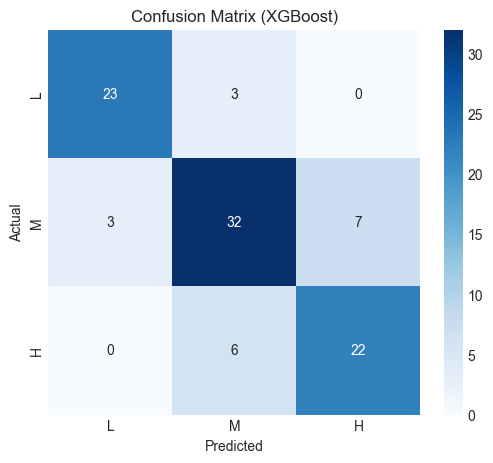

In [8]:
# Confusion Matrix (XGBoost)
cm = confusion_matrix(y_test, predictions['XGBoost'])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['L', 'M', 'H'], yticklabels=['L', 'M', 'H'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (XGBoost)')
plt.show()

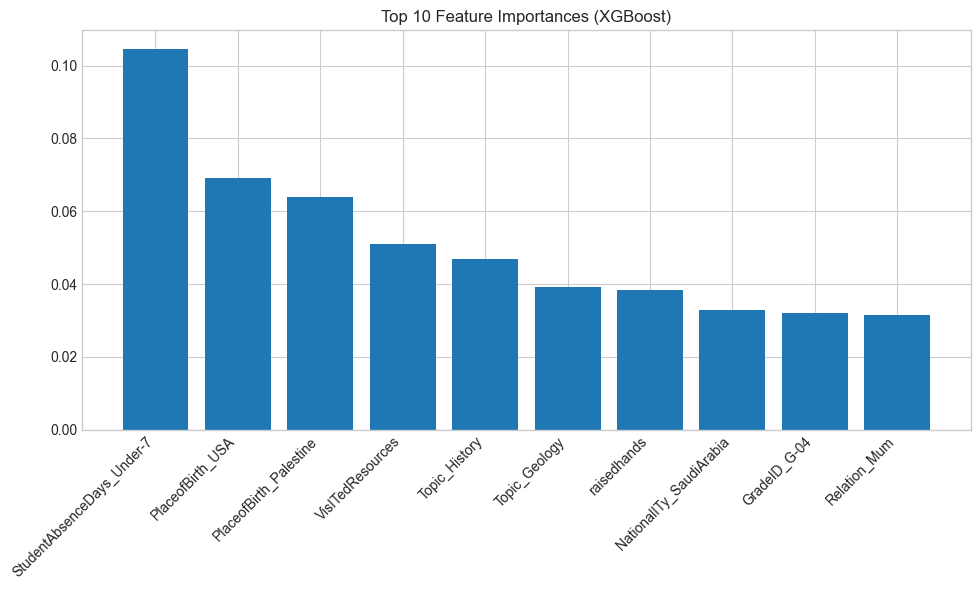

In [9]:
# Feature Importance (XGBoost)
xgb_model = models['XGBoost']
importances = xgb_model.feature_importances_
feature_names = X_encoded.columns

# Top 10 Features
indices = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(10, 6))
plt.title("Top 10 Feature Importances (XGBoost)")
plt.bar(range(10), importances[indices], align="center")
plt.xticks(range(10), feature_names[indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Key Takeaways (핵심 요약)
1.  **참여도의 중요성**: `VisITedResources`, `raisedhands`, `StudentAbsenceDays` 등이 상위 중요 변수로 나타났습니다. 이는 학생의 적극적인 수업 참여와 출석이 성적에 결정적임을 증명합니다.
2.  **부모의 역할**: `Relation`, `ParentAnsweringSurvey` 등 가정 환경 변수도 유의미한 영향을 미쳤습니다.
3.  **모델 성능**: XGBoost 모델이 다중 클래스 분류 문제에서 우수한 성능을 보였습니다. L/M/H 등급 간의 경계를 잘 구분하고 있습니다.
